# Alpha lifetime

An script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams


sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2


from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Sat May 20 13:01:27 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-20 13:01:28


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [5]:
#run_number = 3628
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number = 3733
#run_number = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
#run_number = 3782
#run_number = 3784
#run_number = 3788
#run_number = 3790
#run_number = 3793
#run_number = 3795
#run_number = 3822
#run_number = 3824
#run_number = 3826
#run_number = 3829
#run_number = 3855
#run_number = 3883

#run_number = 3614

#run_number =  3988
#run_number =  3998
#run_number = 4002
#run_number = 4021
#run_number = 4027
run_number = 4029



In [6]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [7]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/dst_4029.root.h5


In [8]:
full = load_dst(ifile)
print(len(full))
full.head()

16250


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.495221e+09,0,1,325.0,371.405304,2093.858556,201625.0,47.001312,2495.417236,...,655462.5,8,453.8375,453.8375,-149.584290,4.653037,149.656642,3.110496,7.484286,6.476862
1,3,1.495221e+09,0,1,350.0,407.478210,2372.784447,235675.0,51.354375,3353.275879,...,654887.5,7,419.2125,419.2125,-3.178458,21.342943,21.578318,1.718633,6.961277,6.515799
2,4,1.495221e+09,0,1,325.0,367.678650,2105.290953,332175.0,18.020625,1147.199463,...,653462.5,1,321.2875,321.2875,15.000000,195.000000,195.576072,1.494024,0.000000,0.000000
3,5,1.495221e+09,0,1,325.0,220.616058,1259.196889,644725.0,31.889187,5425.520508,...,652512.5,8,7.7875,7.7875,191.997480,-47.022925,197.671920,-0.240186,6.611070,5.840869
4,6,1.495221e+09,0,1,325.0,347.994385,1950.323349,377950.0,45.356250,4381.107422,...,655012.5,9,277.0625,277.0625,-16.502658,10.475339,19.546622,2.576001,6.822567,7.636231


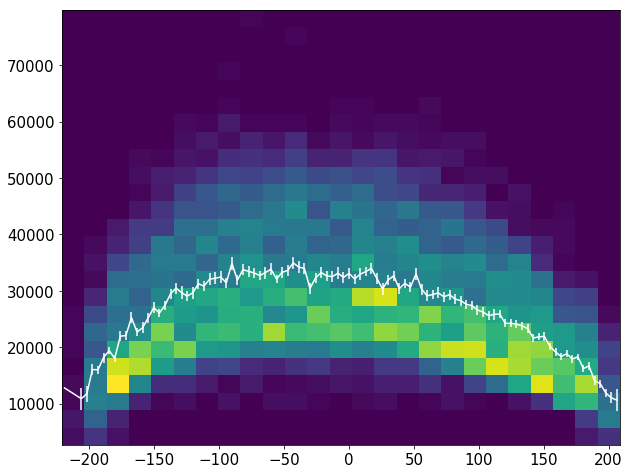

In [9]:
plt.figure(figsize=(10,8))
c = full
c = full[full.Y > -100]
c = c[c.Y <  100]
#c = c[c.Z > 100]
#plt.scatter(c.X, c.S2e)
a = fitf.profileX(c.X, c.S2e, 100)
plt.hist2d(c.X, c.S2e, bins=25)
#plt.ylim((50000,150000))
plt.errorbar(*a, c='white')
plt.show()


In [12]:
fid = full[full.R     <  100*units.mm] # michel sorel cuts

In [17]:
len(fid)

4305

In [18]:
len(full)

16250

In [19]:
r = event_rate(full)

In [20]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 5.086903087258199 evts/s


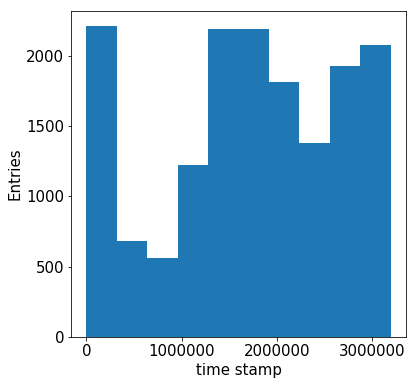

In [21]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

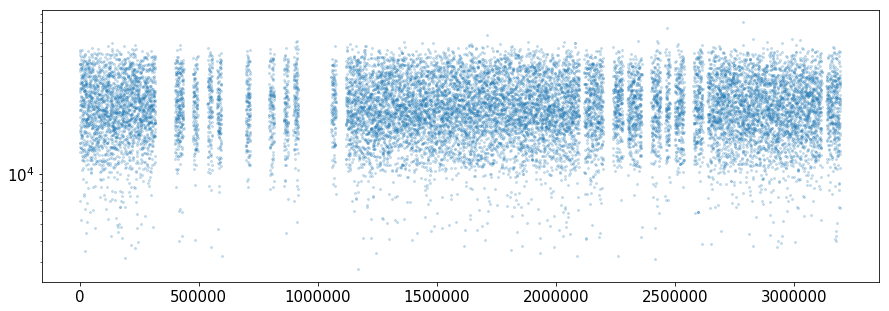

In [22]:
plt.figure(figsize=(15,5))
plt.scatter(1e+3*(full.time - full.time[0]), full.S2e, alpha=.2, s=4)
plt.yscale('log')
plt.show()

In [23]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

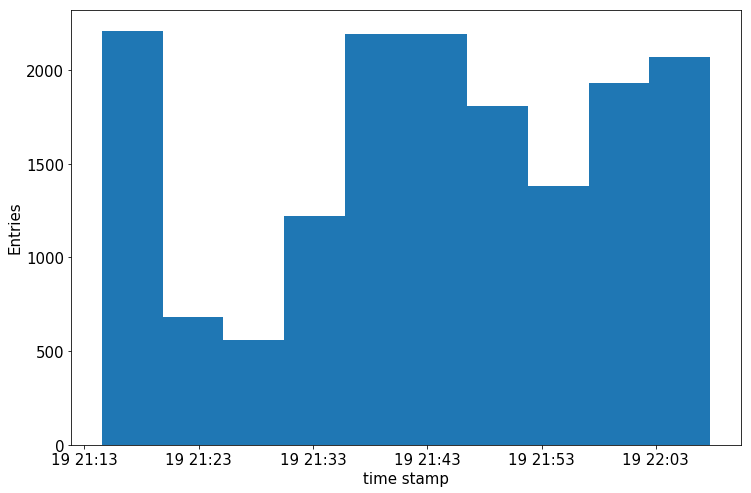

In [24]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [25]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [26]:
print(st)

2017-05-19 22:07:46


In [27]:
print(full.time.index[-1])

16249


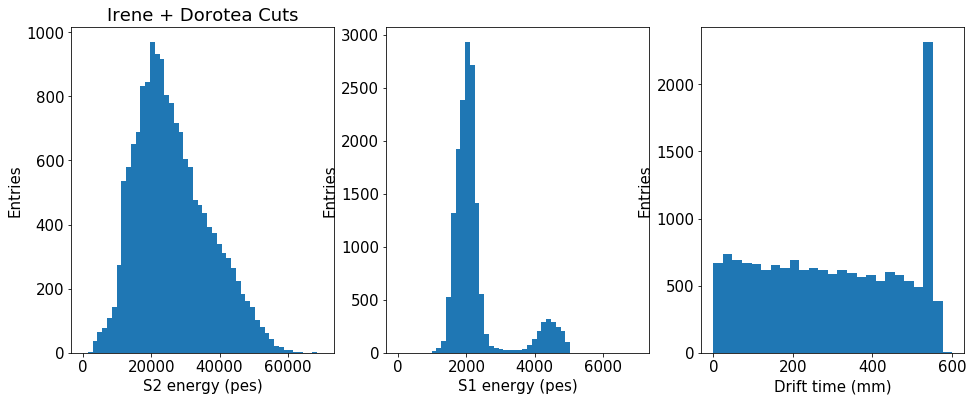

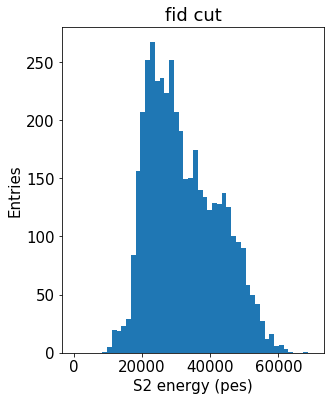

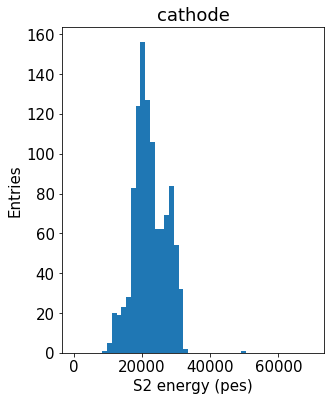

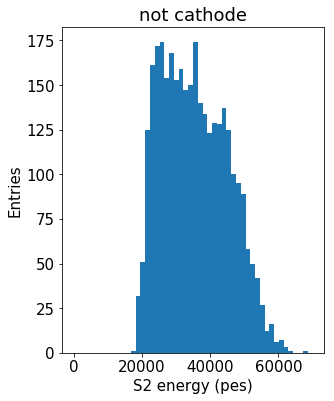

In [29]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

#ax = plt.subplot(1, 3, 2)
#plt.hist(fidc.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fidc.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fid.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fid cut')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 2)
plt.hist(fid[in_range(fid.Z, 500, 600)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('cathode')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 3)
plt.hist(fid[in_range(fid.Z, 0, 500)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('not cathode')

#ax = plt.subplot(1, 3, 2)
#plt.hist(fid.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fid.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

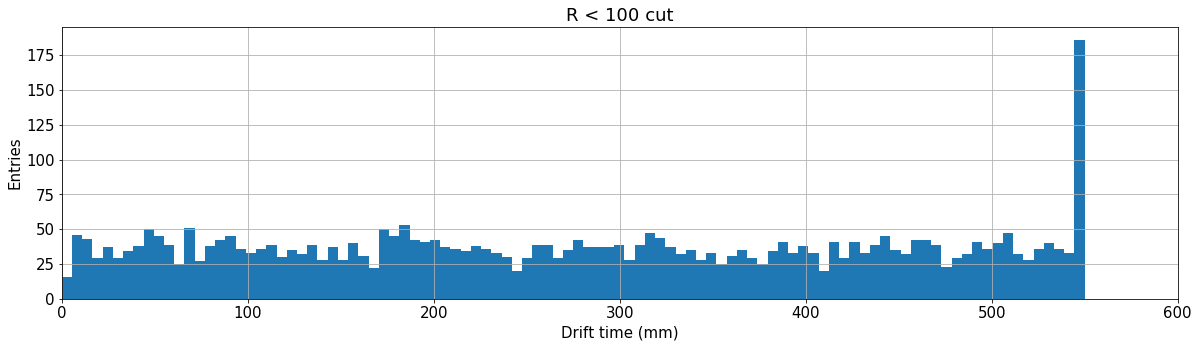

In [30]:
plt.figure(figsize=(20,5))
b = plt.hist(fid.Z, 100, (0, 550))
plt.xlim(0,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('R < 100 cut')




### Dependence with Z all alphas

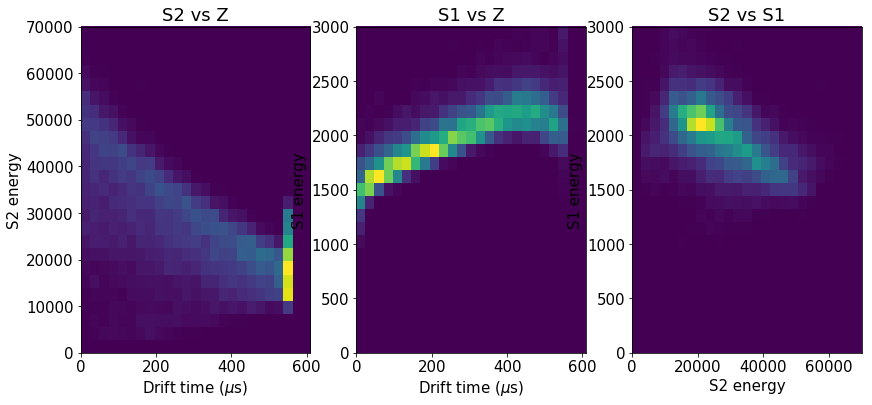

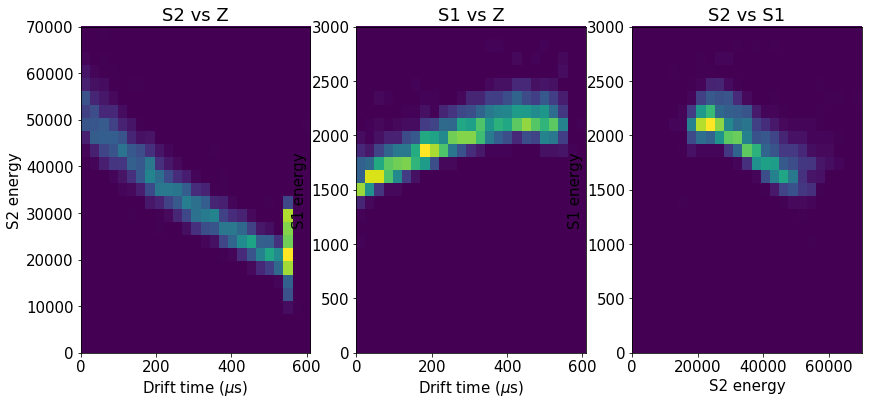

In [31]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [35]:
#core = blk[blk.R < 100]
core = fid
print("Ratio wrt full:", len(core)/len(full))

cathode = full[full.Z > 500]
#core2 = core2[core2.Z < 500]

#core= fid

Ratio wrt full: 0.26492307692307693


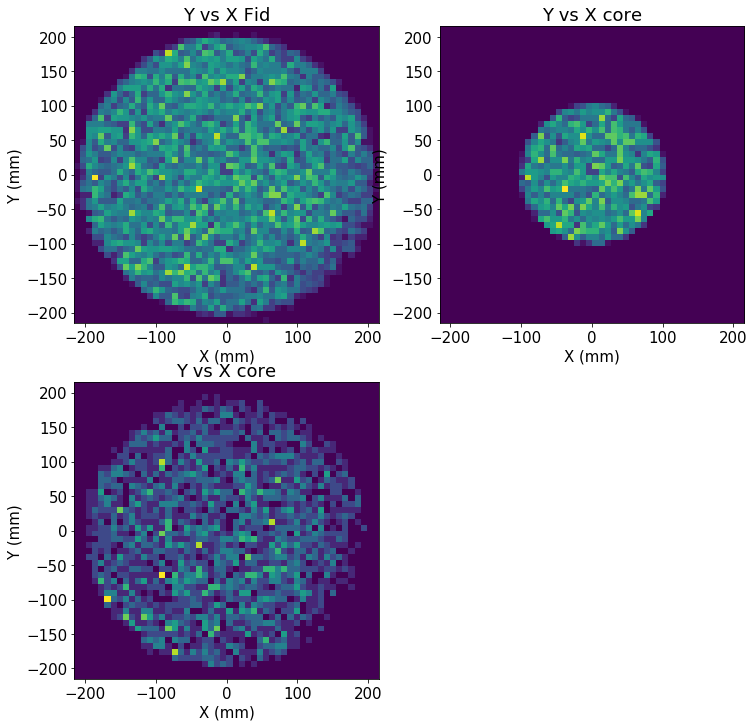

In [36]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,12)
plt.figure(figsize=figsize)
ax = plt.subplot(2, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(2, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

ax = plt.subplot(2, 2, 3)
plt.hist2d(cathode.X, cathode.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

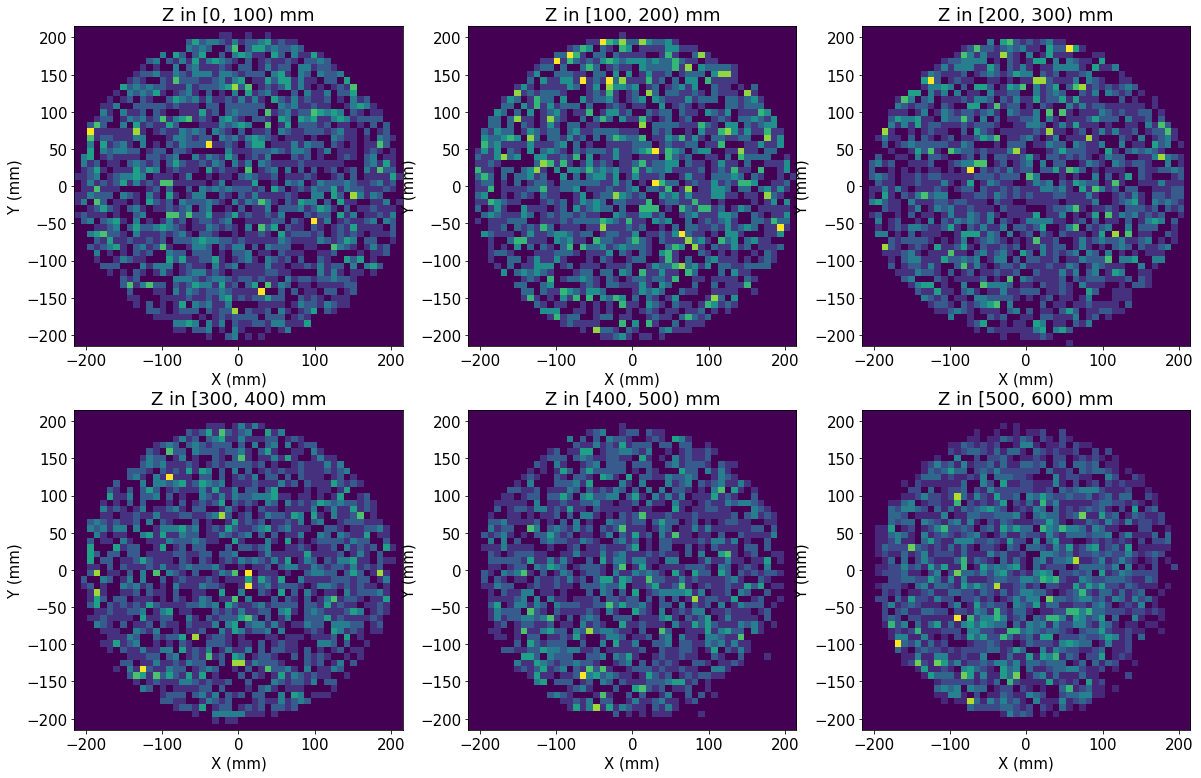

In [37]:
figsize=(20,20)
plt.figure(figsize=figsize)
ax = plt.subplot(3, 3, 1)

for i in range(6):

    ax = plt.subplot(3, 3, i+1)
    plt.hist2d(full[in_range(full.Z, i*100, (i+1)*100)].X, full[in_range(full.Z, i*100, (i+1)*100)].Y,
               (50, 50), range=(xrange, yrange))
    labels("X (mm)", "Y (mm)")
    plt.title('Z in [' + str(i*100) + ', ' + str((i+1)*100) + ') mm')

### Z correction for bulk 

#### S2

fit par[0] = 53448.22259626623 error = 162.94347150826258
fit par[1] = -564.5237774009332 error = 4.07800640263679
degrees of freedom = 2
chi2 = 0.6782405386751627


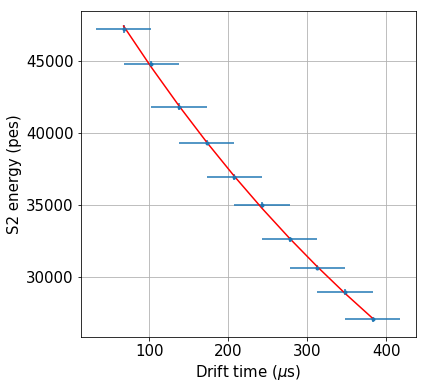

In [38]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

#### Constrain fiducial in z

In [39]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.13993846153846154


#### Fit S2 in fiducial 

fit par[0] = 41096.228969150696 error = 393.0550496525617
fit par[1] = -584.99698201464 error = 13.054904206741181
degrees of freedom = 2
chi2 = 1.1819715592175484


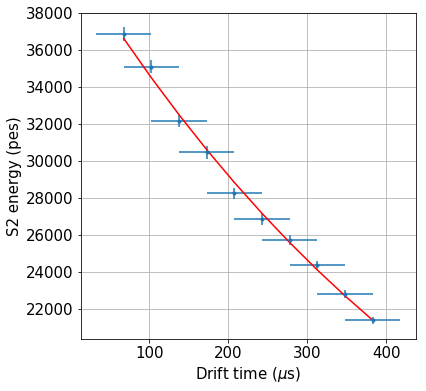

In [41]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(full.Z, full.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

### S2 corrections

In [42]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-05-19 21:14:31 t1 = 2017-05-19 22:07:46


using data set with length 4305
t0 = 2017-05-19 21:14:31 (index = 0) t1 = 2017-05-19 22:07:45 (index = 4305)
bin length = 861
 ---fit over events between 0 and 860
time0 = 2017-05-19 21:14:31 time1 = 2017-05-19 21:28:52
size of time leg = 860
fit par[0] = 53960.851917601074 error = 274.3579194409991
fit par[1] = -542.8740722010357 error = 6.605837737550189
degrees of freedom = 2
chi2 = 0.5817316849220625
 ---fit over events between 861 and 1721
time0 = 2017-05-19 21:28:53 time1 = 2017-05-19 21:40:11
size of time leg = 860
fit par[0] = 53064.28061291018 error = 482.77171156995234
fit par[1] = -580.1483730654606 error = 13.630283960735209
degrees of freedom = 2
chi2 = 1.1239825137294637
 ---fit over events between 1722 and 2582
time0 = 2017-05-19 21:40:12 time1 = 2017-05-19 21:47:59
size of time leg = 860
fit par[0] = 53918.39839332486 error = 600.087318905341
fit par[1] = -547.3651471490223 error = 13.714010305488264
degrees of freedom = 2
chi2 = 1.1732472909836187
 ---fit over events b

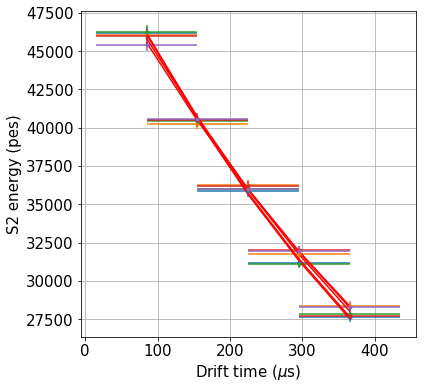

In [44]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=core, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [45]:
plot_options()

In [46]:
TSTAMP

['2017-05-19 21:28:52',
 '2017-05-19 21:40:11',
 '2017-05-19 21:47:59',
 '2017-05-19 21:59:13',
 '2017-05-19 22:07:45']

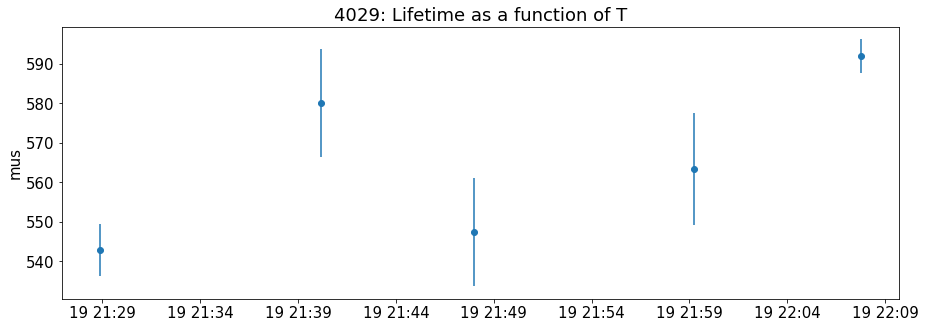

In [47]:
figsize=(15,5)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()



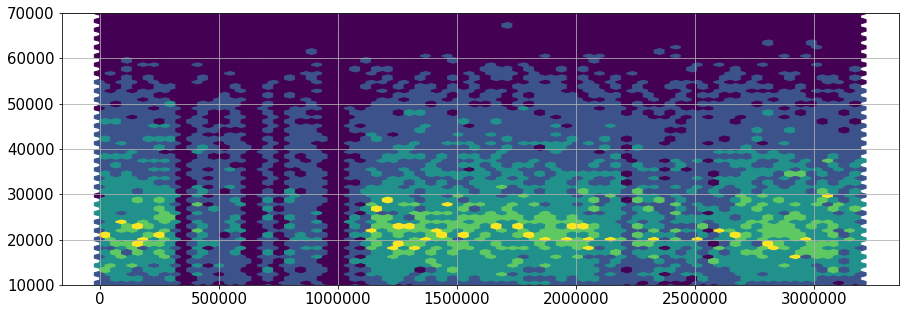

In [48]:
plt.figure(figsize=figsize)
plt.hexbin(1e+3*(full.time - full.time[0]), full.S2e, bins=5, gridsize=70)
#plt.yscale('log')
plt.ylim(10000,70000)
#plt.ylabel('S2e')
plt.grid(True)
plt.show()